In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import levenberg_marquardt
from matplotlib.pyplot import figure
import heston 
from importlib import reload
reload(heston)
from heston import calibrate_heston, get_tick
import datetime
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from scipy import stats as sps
from typing import Union
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [2]:
%%time
raw = pd.HDFStore('../datasets/eth-20230224.h5','r').get("/eth")

CPU times: user 21.3 s, sys: 3.09 s, total: 24.3 s
Wall time: 26.2 s


In [3]:
def process_data(data):
    # only options
    df = data.copy()
    df = df[(df["instrument"].str.endswith("C")) | (df["instrument"].str.endswith("P"))].sort_values("dt")
    df["type"] = np.where(df["instrument"].str.endswith("C"), "call", "put")
    
    perpetuals = data[data["instrument"].str.endswith("PERPETUAL")][["dt", "price"]].copy()
    perpetuals = perpetuals.rename(columns = {"price": "underlying_price"}).sort_values("dt")
    
    def get_strike(x):
        return int(x.split("-")[2])
    
    def get_expiration(x):
        return x.split("-")[1]
    

    df["strike_price"] = df["instrument"].apply(get_strike)
    df["expiration"] = df["instrument"].apply(get_expiration)
    
    def unix_time_millis(dt):
        epoch = datetime.datetime.utcfromtimestamp(0)
        return int((dt - epoch).total_seconds() * 1000_000)
    
    def get_normal_date(s):
        """Function to convert date to find years to maturity"""
        monthToNum = {
            "JAN": 1,
            "FEB": 2,
            "MAR": 3,
            "APR": 4,
            "MAY": 5,
            "JUN": 6,
            "JUL": 7,
            "AUG": 8,
            "SEP": 9,
            "OCT": 10,
            "NOV": 11,
            "DEC": 12,
        }

        full_date = s.split("-")[1]
        try:
            day = int(full_date[:2])
            month = monthToNum[full_date[2:5]]
        except:
            day = int(full_date[:1])
            month = monthToNum[full_date[1:4]]
        
        year = int("20" + full_date[-2:])
        exp_date = datetime.datetime(year, month, day)
        return unix_time_millis(exp_date)
    
    df["dt"] = pd.to_datetime(df["dt"])
    perpetuals["dt"] = pd.to_datetime(perpetuals["dt"])
    
    df = pd.merge_asof(df, perpetuals, on="dt",
                       tolerance=pd.Timedelta('7 minutes'),
                       direction='nearest',)
    
    df["timestamp"] = df["dt"].apply(unix_time_millis)
    df["expiration"] = df["instrument"].apply(get_normal_date)
    df = df.rename(columns = {"price": "mark_price"})
    
    
    return df


In [4]:
%%time
start = process_data(raw)


CPU times: user 49.4 s, sys: 17.9 s, total: 1min 7s
Wall time: 1min 17s


In [325]:
df = start.copy()
# df = df[(df["timestamp"]>=1672000000000000) & (df["timestamp"]<=1672800000000000)]
df

,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
0,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-1700-C,call,1700,1669334400000000,1133.90,1669036104511000
1,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2400-C,call,2400,1669334400000000,1133.90,1669036104511000
2,2022-11-21 13:08:24.511,0.0020,ETH-25NOV22-700-P,put,700,1669334400000000,1133.90,1669036104511000
3,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3800-C,call,3800,1669334400000000,1133.90,1669036104511000
4,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3400-C,call,3400,1669334400000000,1133.90,1669036104511000
...,...,...,...,...,...,...,...,...
7498621,2023-02-24 07:13:46.716,0.0300,ETH-24FEB23-1700-P,put,1700,1677196800000000,1651.85,1677222826716000
7498622,2023-02-24 07:13:47.576,0.2975,ETH-24FEB23-1200-C,call,1200,1677196800000000,1651.85,1677222827576000
7498623,2023-02-24 07:13:51.208,0.0015,ETH-24FEB23-1650-P,put,1650,1677196800000000,1651.85,1677222831208000
7498624,2023-02-24 07:13:55.748,0.2980,ETH-24FEB23-1200-C,call,1200,1677196800000000,1651.85,1677222835748000


In [ ]:
# df_s = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
# df_s = df_s.drop(columns = ["exchange", "open_interest", 
#                     "last_price", "bid_price", "bid_amount", "bid_iv",
#                            "ask_price", "ask_amount", "ask_iv", "underlying_index",
#                            "delta", "gamma", "vega", "theta" ,"rho"])
# currency = "ETH"
# ind = [symbol.startswith(currency) for symbol in df_s.symbol]
# df_s = df_s[ind].reset_index(drop=True)
# # df = df[df["expiration"] == 1680249600000000]
# # after expiration
# # df = df[df["timestamp"] > 1669881600000000]
# # df = df[df["timestamp"]<=1669928620213347.0]

# df = df_s.copy()
# df = df[df["expiration"].isin([1680249600000000, 1688112000000000, 
#                                1672387200000000, 1674806400000000, 1669968000000000, 
#                                1695974400000000, 1677225600000000])]

# See params dynamic

In [350]:
%%time
# calibrate base
number_of_dots = 50
timestamps_hm = []

params_all = []
params_nu0 = []
params_nu0_and_nu_bar = []
params_nu0_and_k = []
params_kappa = []


errors_all = []
errors_nu0 = []
errors_nu0_and_nu_bar = []
errors_nu0_and_k = []
errors_kappa = []


a = np.float64(1.0)  # kappa    a                 |  mean reversion rate | kappa (Article) | kappa (Roland's)
b = np.float64(1.3)  # v_infinity                |  long term variance | nu_bar           | alpha_bar 
c = np.float64(1.0)  # sigma                    |  volatility of volatility | sigma      | mu
rho = np.float64(-0.4)  # rho                    |  correlation between spot and vol |rho | rho
v0 = np.float64(0.65) # init variance            | initial variance | nu_0                | alpha_0
start_params = np.array([a, b, c, rho, v0])

print("Optimize first params with random start once")
calibrated_params_all, first_error_all, _ = calibrate_heston(df = df, 
                                                        start_params = start_params, 
                                                        calibration_type = "all")
calibrated_params_nu0, first_error_nu0, _ = calibrate_heston(df = df, 
                                                        start_params = start_params, 
                                                        calibration_type = "nu0")
calibrated_params_nu0_and_nu_bar, first_error_nu0_and_nu_bar, _ = calibrate_heston(df = df, 
                                                        start_params = start_params, 
                                                        calibration_type = "nu0_and_nu_bar")
calibrated_params_nu0_and_k, first_error_nu0_and_k, _ = calibrate_heston(df = df, 
                                                        start_params = start_params, 
                                                        calibration_type = "nu0_and_k")
calibrated_params_kappa, first_error_kappa, _ = calibrate_heston(df = df, 
                                                        start_params = start_params, 
                                                        calibration_type = "kappa")


print("All first calibrated:", [round(x, 3) for x in calibrated_params_all], "error:", first_error_all)
print("nu0 first calibrated:", [round(x, 3) for x in calibrated_params_nu0], "error:", first_error_nu0)
print("nu0_and_nu_bar first calibrated:", [round(x, 3) for x in calibrated_params_nu0_and_nu_bar],
              "error:", first_error_nu0_and_nu_bar)
print("nu0_and_k first calibrated:", [round(x, 3) for x in calibrated_params_nu0_and_k],
              "error:", first_error_nu0_and_k)
print("kappa first calibrated:", [round(x, 3) for x in calibrated_params_kappa],
              "error:", first_error_kappa)

# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 12:00:00")].copy()
timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    try:
        # zero params for each point are params from last step
        calibrated_params_all, error_all, _ = calibrate_heston(df = df, start_params = calibrated_params_all, 
                                    timestamp = timestamp, calibration_type = "all")
        print("All calibrated:", [round(x, 3) for x in calibrated_params_all], 
              "error:", error_all)
        params_all.append(calibrated_params_all)
        errors_all.append(error_all)
        
        
        calibrated_params_nu0, error_nu0, _ = calibrate_heston(df = df, start_params = calibrated_params_nu0, 
                                    timestamp = timestamp, calibration_type = "nu0")
        print("nu0 calibrated:", [round(x, 3) for x in calibrated_params_nu0], 
              "error:", error_nu0)
        params_nu0.append(calibrated_params_nu0)
        errors_nu0.append(error_nu0)
        
        
        calibrated_params_nu0_and_nu_bar, error_nu0_and_nu_bar, _ = calibrate_heston(df = df, start_params = calibrated_params_nu0_and_nu_bar, 
                                    timestamp = timestamp, calibration_type = "nu0_and_nu_bar")
        print("nu0nb calibrated:", [round(x, 3) for x in calibrated_params_nu0_and_nu_bar],
              "error:", error_nu0_and_nu_bar)
        params_nu0_and_nu_bar.append(calibrated_params_nu0_and_nu_bar)
        errors_nu0_and_nu_bar.append(error_nu0_and_nu_bar)
        
        
        calibrated_params_nu0_and_k, error_nu0_and_k, _ = calibrate_heston(df = df, start_params = calibrated_params_nu0_and_k, 
                                    timestamp = timestamp, calibration_type = "nu0_and_k")
        print("nu0k calibrated:", [round(x, 3) for x in calibrated_params_nu0_and_k],
              "error:", error_nu0_and_k)
        params_nu0_and_k.append(calibrated_params_nu0_and_k)
        errors_nu0_and_k.append(error_nu0_and_k)
        
        
        calibrated_params_kappa, error_kappa, _ = calibrate_heston(df = df, start_params = calibrated_params_kappa, 
                                    timestamp = timestamp, calibration_type = "kappa")
        print("kappa calibrated:", [round(x, 3) for x in calibrated_params_kappa],
              "error:", error_kappa)
        params_kappa.append(calibrated_params_kappa)
        errors_kappa.append(error_kappa)
        
        print("    ")
        # save timestame that could calibrate
        timestamps_hm.append(timestamp)
    except:
        continue

    

timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps_hm]
params_all = np.array(params_all).T
params_nu0 = np.array(params_nu0).T
params_nu0_and_nu_bar = np.array(params_nu0_and_nu_bar).T
params_nu0_and_k = np.array(params_nu0_and_k).T
params_kappa = np.array(params_kappa).T




Optimize first params with random start once
All first calibrated: [68.545, 0.541, 12.798, -0.084, 0.438] error: 0.1827210514893162
nu0 first calibrated: [61.372, 0.564, 12.061, -0.083, 0.417] error: 0.18310369790335995
nu0_and_nu_bar first calibrated: [0.0, 0.001, 1.88, -0.18, 0.417] error: 0.542459266272994
nu0_and_k first calibrated: [0.217, 23.613, 6.141, -0.084, 0.417] error: 0.2145812455966803
kappa first calibrated: [0.236, 133.478, 9.269, -0.094, 0.002] error: 0.19847294009705715


  0%|          | 0/50 [00:00<?, ?it/s]

kappa calibrated: [0.225, 17.707, 6.198, -0.055, 0.449] error: 0.13292893247693588
    
kappa calibrated: [0.225, 17.445, 6.318, -0.08, 0.452] error: 0.12387501479524145
    
kappa calibrated: [0.224, 17.171, 6.361, -0.079, 0.45] error: 0.12365738354242486
    
kappa calibrated: [0.224, 17.521, 6.308, -0.071, 0.449] error: 0.13312909052805366
    
kappa calibrated: [0.224, 17.084, 6.345, -0.059, 0.45] error: 0.1299776752331471
    
kappa calibrated: [0.223, 20.373, 6.389, -0.065, 0.441] error: 0.12748681200546647
    
kappa calibrated: [0.223, 18.22, 6.417, -0.073, 0.449] error: 0.11717933875008328
    
kappa calibrated: [0.223, 15.931, 6.295, -0.072, 0.457] error: 0.11739218178961115
    
kappa calibrated: [0.224, 16.236, 6.205, -0.074, 0.454] error: 0.11577258349149762
    
kappa calibrated: [0.223, 13.982, 5.973, -0.075, 0.462] error: 0.11915345023197683
    
kappa calibrated: [0.223, 14.598, 6.11, -0.089, 0.463] error: 0.10927159261137034
    
kappa calibrated: [0.223, 14.024, 6.27

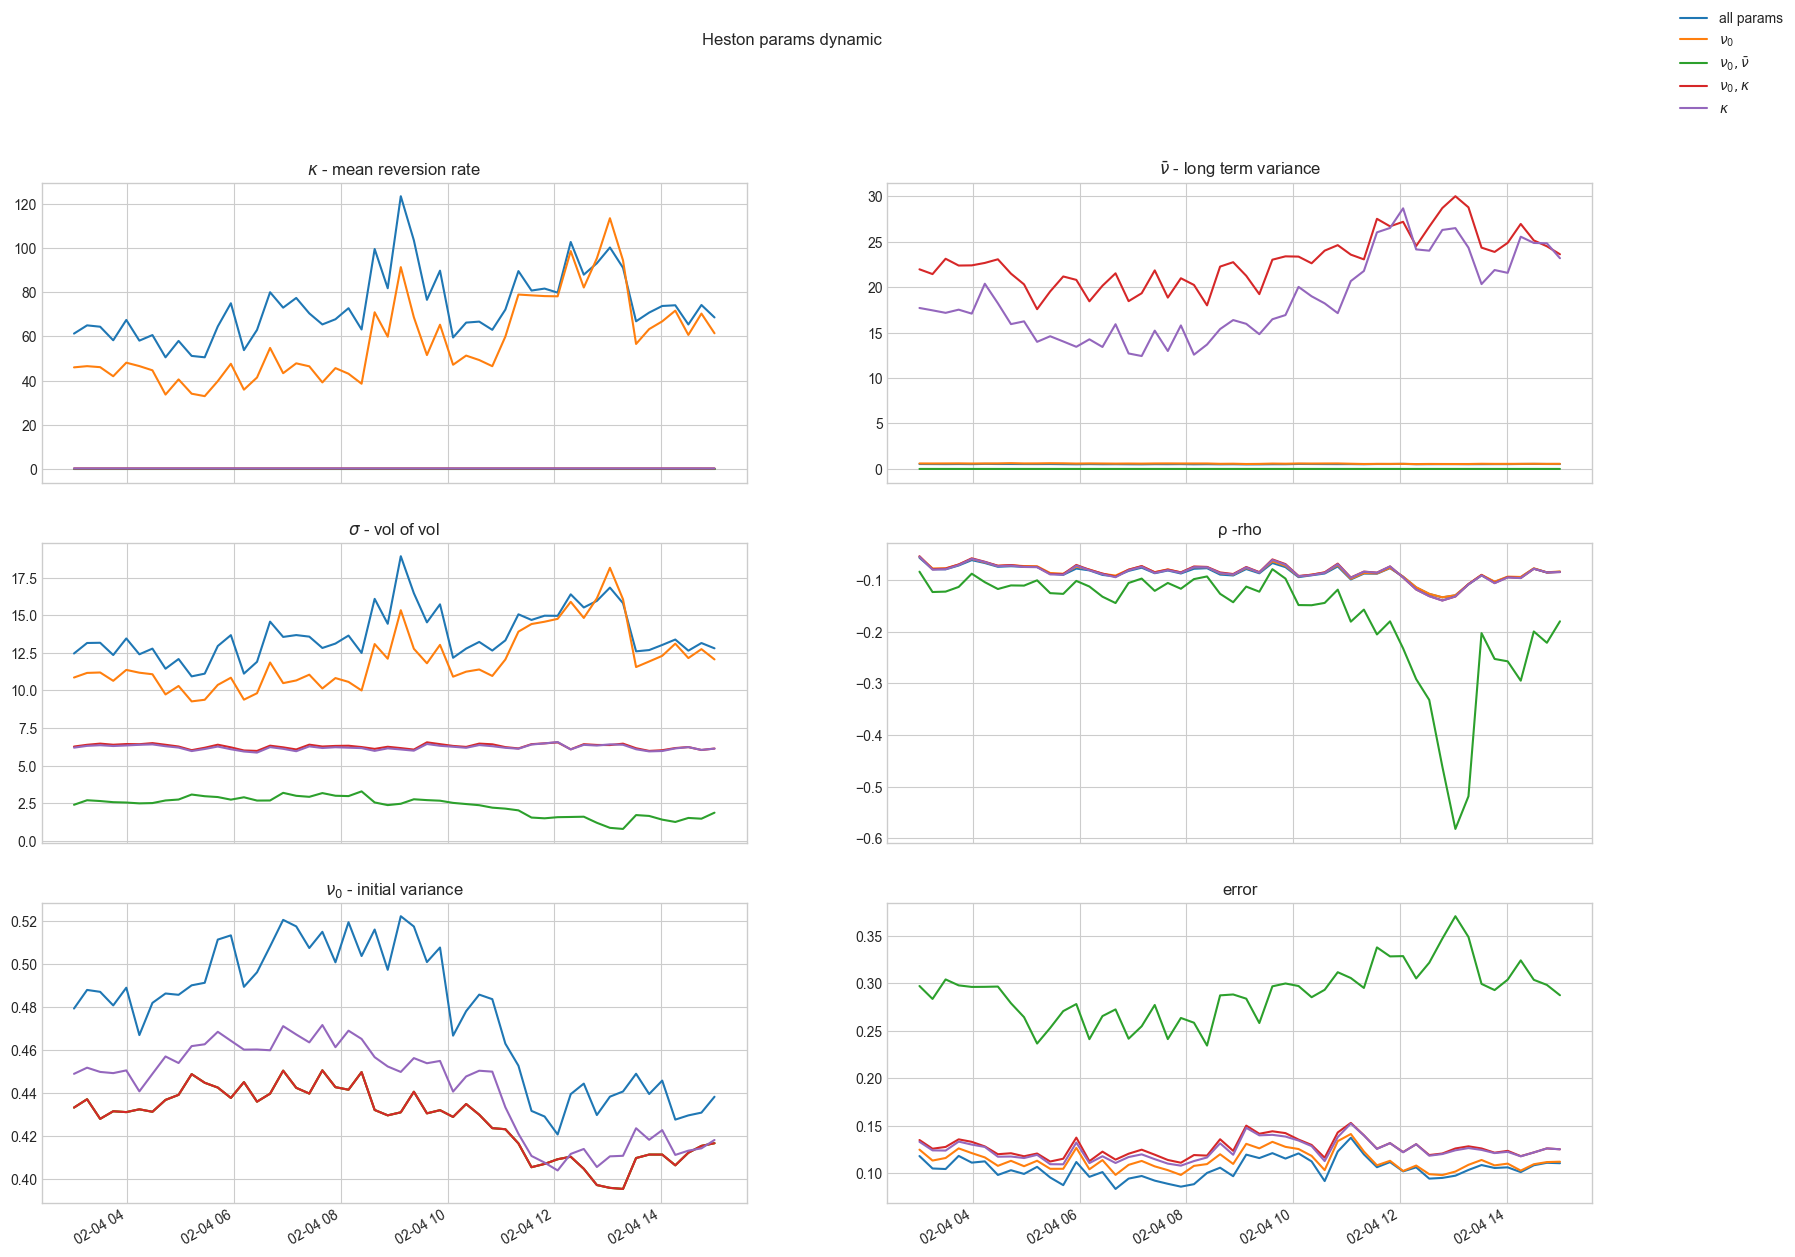

In [356]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

axs[0, 0].plot(timestamps_hm, params_all[0])
axs[0, 1].plot(timestamps_hm, params_all[1])
axs[1, 0].plot(timestamps_hm, params_all[2], label = "all params")
axs[1, 1].plot(timestamps_hm, params_all[3])
axs[2, 0].plot(timestamps_hm, params_all[4])
axs[2, 1].plot(timestamps_hm, errors_all)

axs[0, 0].plot(timestamps_hm, params_nu0[0])
axs[0, 1].plot(timestamps_hm, params_nu0[1])
axs[1, 0].plot(timestamps_hm, params_nu0[2], label = r"$\nu_0$")
axs[1, 1].plot(timestamps_hm, params_nu0[3])
axs[2, 0].plot(timestamps_hm, params_nu0[4])
axs[2, 1].plot(timestamps_hm, errors_nu0)

axs[0, 0].plot(timestamps_hm, params_nu0_and_nu_bar[0])
axs[0, 1].plot(timestamps_hm, params_nu0_and_nu_bar[1])
axs[1, 0].plot(timestamps_hm, params_nu0_and_nu_bar[2], label = r"$\nu_0, \bar{\nu}$")
axs[1, 1].plot(timestamps_hm, params_nu0_and_nu_bar[3])
axs[2, 0].plot(timestamps_hm, params_nu0_and_nu_bar[4])
axs[2, 1].plot(timestamps_hm, errors_nu0_and_nu_bar)

axs[0, 0].plot(timestamps_hm, params_nu0_and_k[0])
axs[0, 1].plot(timestamps_hm, params_nu0_and_k[1])
axs[1, 0].plot(timestamps_hm, params_nu0_and_k[2], label = r"$\nu_0, \kappa$")
axs[1, 1].plot(timestamps_hm, params_nu0_and_k[3])
axs[2, 0].plot(timestamps_hm, params_nu0_and_k[4])
axs[2, 1].plot(timestamps_hm, errors_nu0_and_k)


axs[0, 0].plot(timestamps_hm, params_kappa[0])
axs[0, 1].plot(timestamps_hm, params_kappa[1])
axs[1, 0].plot(timestamps_hm, params_kappa[2], label = r"$\kappa$")
axs[1, 1].plot(timestamps_hm, params_kappa[3])
axs[2, 0].plot(timestamps_hm, params_kappa[4])
axs[2, 1].plot(timestamps_hm, errors_kappa)


axs[0, 0].set_title(r"$\kappa$ - mean reversion rate")
axs[0, 1].set_title(r"$\bar{\nu}$ - long term variance")
axs[1, 0].set_title(r"$\sigma$ - vol of vol")
axs[1, 1].set_title("ρ -rho")
axs[2, 0].set_title(r"$\nu_0$ - initial variance")
axs[2, 1].set_title("error")



# for i in range(3):
#     for j in range(2):
#         for exp in expirarions:
#             axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#             axs[i, j].axvline(x=exp, color = "black", linestyle  = "--")
#             if i == j == 0:
#                 axs[i, j].axvline(x=exp, color = "black", linestyle  = "--", label = exp)
#                 pass


plt.figlegend() 
fig.suptitle("Heston params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Vol smile

In [272]:
stamp = df.sample(1).iloc[0].timestamp
# print(df.timestamp.max() - df.timestamp.min())
print(stamp)

1675118523859000


In [342]:
# 1673321843011000

needed_stamp = 1673321843011000
a = np.float64(1.0)  # kappa    a                 |  mean reversion rate | kappa (Article) | kappa (Roland's)
b = np.float64(1.3)  # v_infinity                |  long term variance | nu_bar           | alpha_bar 
c = np.float64(1.0)  # sigma                    |  volatility of volatility | sigma      | mu
rho = np.float64(-0.4)  # rho                    |  correlation between spot and vol |rho | rho
v0 = np.float64(0.65) # init variance            | initial variance | nu_0                | alpha_0
start_params = np.array([a, b, c, rho, v0])

pars_all, err_all, C_all = calibrate_heston(df = df, start_params = start_params, timestamp = needed_stamp,
                                calibration_type= "all")

pars_nu0, err_nu0, C_nu0 = calibrate_heston(df= df, start_params = start_params, timestamp = needed_stamp,
                                calibration_type= "nu0")

pars_and_nu_bar, err_and_nu_bar, C_and_nu_bar = calibrate_heston(df= df, start_params = start_params, 
                                                                 timestamp = needed_stamp,
                                calibration_type= "nu0_and_nu_bar")

pars_nu0_and_k, err_nu0_and_k, C_nu0_and_k = calibrate_heston(df= df, start_params = start_params, 
                                                                 timestamp = needed_stamp,
                                calibration_type= "nu0_and_k")

pars_kappa, err_kappa, C_kappa = calibrate_heston(df= df, start_params = start_params, 
                                                    timestamp = needed_stamp,
                                calibration_type= "kappa")

def round_params(params, n_signs = 3):
    return [round(x, n_signs) for x in params]
    

print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")
print(r"$\nu_0$")
print(round_params(pars_nu0))
print(err_nu0)
print("   ")
print(r"$\nu_0, \bar{\nu}$")
print(round_params(pars_and_nu_bar, 7))
print(err_and_nu_bar)
print("   ")
print(r"$\nu_0, \kappa$")
print(round_params(pars_nu0_and_k))
print(err_nu0_and_k)
print("   ")
print(r"$\kappa$")
print(round_params(pars_kappa))
print(err_kappa)
print("   ")

All:
[88.732, 0.3, 18.596, -0.095, 0.47]
0.10336662438207314
   
$\nu_0$
[0.496, 3.711, 8.016, -0.097, 0.339]
0.14459992091863605
   
$\nu_0, \bar{\nu}$
[0.0001, 0.0003807, 6.663357, -0.117194, 0.3385814]
0.15315476617192547
   
$\nu_0, \kappa$
[0.378, 4.736, 8.0, -0.097, 0.339]
0.14465788030683852
   
$\kappa$
[0.378, 0.0, 8.054, -0.092, 0.37]
0.13736845378361187
   


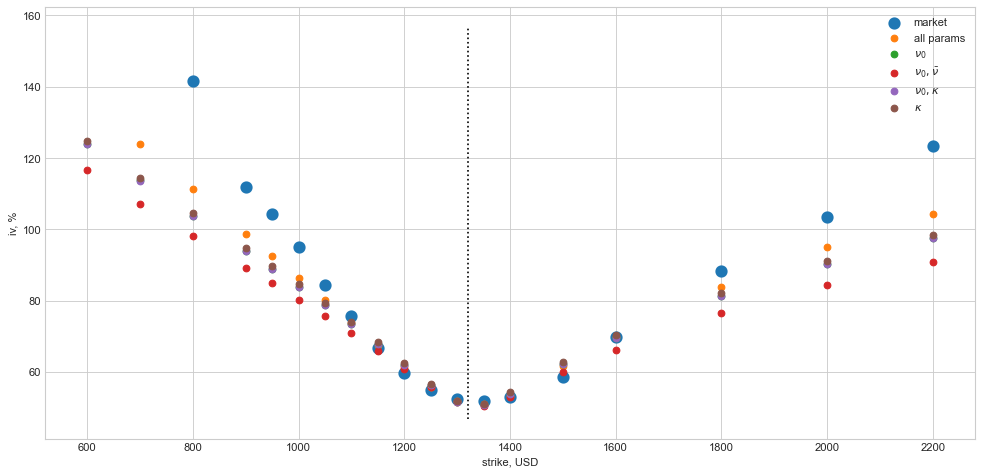

In [347]:
figure(figsize=(15, 7), dpi=80)

exp = C_all.sample(1).expiration.iloc[0]
C_sing_exp_all = C_all[C_all["expiration"] == exp]
C_sing_exp_nu0 = C_nu0[C_nu0["expiration"] == exp]
C_sing_exp_and_nu_bar = C_and_nu_bar[C_and_nu_bar["expiration"] == exp]
C_sing_exp_nu0_and_k = C_nu0_and_k[C_nu0_and_k["expiration"] == exp]
C_sing_exp_kappa = C_kappa[C_kappa["expiration"] == exp]

plt.scatter(C_sing_exp_all["strike_price"], C_sing_exp_all["market_iv"], label = "market", linewidths = 5)
plt.scatter(C_sing_exp_all["strike_price"], C_sing_exp_all["calibrated_iv"], label = "all params")
plt.scatter(C_sing_exp_nu0["strike_price"], C_sing_exp_nu0["calibrated_iv"], label = r"$\nu_0$")
plt.scatter(C_sing_exp_and_nu_bar["strike_price"], C_sing_exp_and_nu_bar["calibrated_iv"], label = r"$\nu_0, \bar{\nu}$")
plt.scatter(C_sing_exp_nu0_and_k["strike_price"], C_sing_exp_nu0_and_k["calibrated_iv"], label = r"$\nu_0, \kappa$")
plt.scatter(C_sing_exp_kappa["strike_price"], C_sing_exp_kappa["calibrated_iv"], label = r"$\kappa$")

plt.vlines([C_sing_exp_all.underlying_price.mean()], C_sing_exp_all.market_iv.min()-5, 
           C_sing_exp_all.market_iv.max() + 15, color = "black", linestyles = "dotted")

plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()

In [ ]:
# single_instr = df[df["instrument"] == df.sample(1).instrument.iloc[0]]
# plt.plot(single_instr["dt"], single_instr["mark_price"])
# plt.plot(df["dt"], df["underlying_price"])